In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [98]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb

In [71]:
np.set_printoptions(linewidth=100)

## Fetch the a single run from WandB

In [15]:
api = wandb.Api()
run = api.run('meta-learning-scaling/sequential-benchmark-baseline/6fmtx2m7')
df = run.history(pandas=True)

In [23]:
print(df.shape)
df[:10]

(118, 70)


,Test AUC,Test Accuracy,"Test Accuracy, Query #1","Test Accuracy, Query #10","Test Accuracy, Query #2","Test Accuracy, Query #3","Test Accuracy, Query #4","Test Accuracy, Query #5","Test Accuracy, Query #6","Test Accuracy, Query #7",...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'bins': [-0.0011030409950762987, -0.001067508...","{'bins': [-0.0028891866095364094, -0.002791859...","{'bins': [-0.0018628956750035286, -0.001812204...","{'_type': 'histogram', 'values': [1, 0, 0, 2, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [2, 1, 4, 5, ...","{'bins': [-0.002993393689393997, -0.0029028125...","{'bins': [-0.002214892767369747, -0.0021436058...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ..."
1,0.754295,74.500000,0.7536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [2, 1, 2, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ...","{'bins': [-0.002361118793487549, -0.0022836846...","{'values': [1, 3, 5, 6, 6, 8, 13, 27, 37, 39, ...","{'values': [1, 1, 0, 0, 0, 0, 3, 0, 0, 4, 1, 4...","{'_type': 'histogram', 'values': [1, 2, 1, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.018434586003422737, -0.0178585052..."
2,0.881109,88.000000,0.8830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 1, 1, ...","{'values': [1, 0, 1, 1, 5, 1, 1, 3, 10, 6, 8, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 2, 0, ...","{'values': [1, 3, 2, 0, 5, 4, 7, 4, 11, 11, 13...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'bins': [-0.01340036652982235, -0.01298160571..."
3,0.955544,95.250000,0.9572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [3, 3, 5, 3, ...","{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 0, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.0051918476819992065, -0.005083194...","{'_type': 'histogram', 'values': [1, 0, 0, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ..."
4,0.671759,67.714286,0.7520,NaN,0.6114,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 1, 0, ...","{'_type': 'histogram', 'values': [2, 0, 1, 1, ...","{'_type': 'histogram', 'values': [3, 0, 6, 5, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.03141821175813675, -0.03043639287...","{'values': [2, 0, 1, 0, 4, 2, 2, 5, 1, 8, 9, 1..."
5,0.712645,70.571429,0.8550,NaN,0.5672,NaN,NaN,NaN,NaN,NaN,...,"{'values': [1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 3, 3...","{'_type': 'histogram', 'values': [2, 2, 4, 4, ...","{'values': [1, 0, 1, 1, 1, 1, 0, 4, 2, 2, 2, 1...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.010801795870065689, -0.0104331290...","{'_type': 'histogram', 'values': [1, 1, 2, 1, ...","{'bins': [-0.00841599516570568, -0.00812252052...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 2, 1, ..."
6,0.713336,71.142857,0.8492,NaN,0.5794,NaN,

## Examples to criterion plot

We discussd plotting the number of examples (for that task) to get back to criterion, as a function of both the total number of tasks the network as learned, and how many times the task was relearned. 

If we just look at the latter, that's easy to plot, since we can just have the number of times the task was learned on the x-axis, and the number of examples on the y-axis. If we want to look at both, that's harder - a 3-D plot? A heatmap in 2-D?

**TODO:** What do we do if the accuracy goes above the threshold and then back below, while training on a given task? I'm assuming for now it doesn't happen, although it theoretically could

First, I can print up both above, in a table .that ends up being upper-triangular. I want a table such that $A[x, y]$ is the number of examples to reach criterion, where $x$ (the row) indicates the number of times the task was learned, and $y$ (the col) indicates how many tasks the network was training on at the time. That is, $A[2, 4]$ should be a task trained on for the 3rd time when the network was training on the fifth task. 

In [95]:
DATASET_CORESET_SIZE = 22500
ACCURACY_THRESHOLD = 0.95
TASK_ACC_COLS = [f'Test Accuracy, Query #{i}' for i in range(1, 11)]


def examples_per_epoch(task, latest_task):
    if task == latest_task:
        return 22500
    
    return 22500 // (latest_task - 1)
    

def parse_run_results_training_to_criterion(run_id):
    current_run = api.run(f'meta-learning-scaling/sequential-benchmark-baseline/{run_id}')
    current_df = run.history(pandas=True)
    
    examples_to_criterion = np.zeros((10, 10))

    first_task_finished = current_df['Test Accuracy, Query #2'].first_valid_index() - 1
    examples_to_criterion[0, 0] = first_task_finished * examples_per_epoch(1, 1)


    for current_task in range(2, 11):
        current_task_start = current_df[f'Test Accuracy, Query #{current_task}'].first_valid_index()

        if current_task == 10:
            current_task_end = current_df.shape[0]
        else:
            current_task_end = current_df[f'Test Accuracy, Query #{current_task + 1}'].first_valid_index()

        current_task_subset = current_df[TASK_ACC_COLS][current_task_start:current_task_end] > 0.95

        for task in range(1, current_task + 1):
            number_times_learned = current_task - task + 1
            number_total_tasks = current_task

            examples_to_criterion[number_times_learned - 1, number_total_tasks - 1] = examples_per_epoch(task, current_task) * \
                (current_task_subset[f'Test Accuracy, Query #{task}'].idxmax() - current_task_start + 1)
            
    return examples_to_criterion
        
    
examples_to_criterion = parse_run_results_training_to_criterion('6fmtx2m7')



In [ ]:
PRINT_HEADERS = ['###'] + [str(x) for x in range(1, 11)]

def pretty_print_results(results):
    result_rows = [[str(i + 1)] + list(results[i]) for i in range(10)]
    print(tabulate.tabulate(result_rows, PRINT_HEADERS, tablefmt='fancy_grid'))
    
    
pretty_print_results(examples_to_criterion)

## Try to plot these quickly

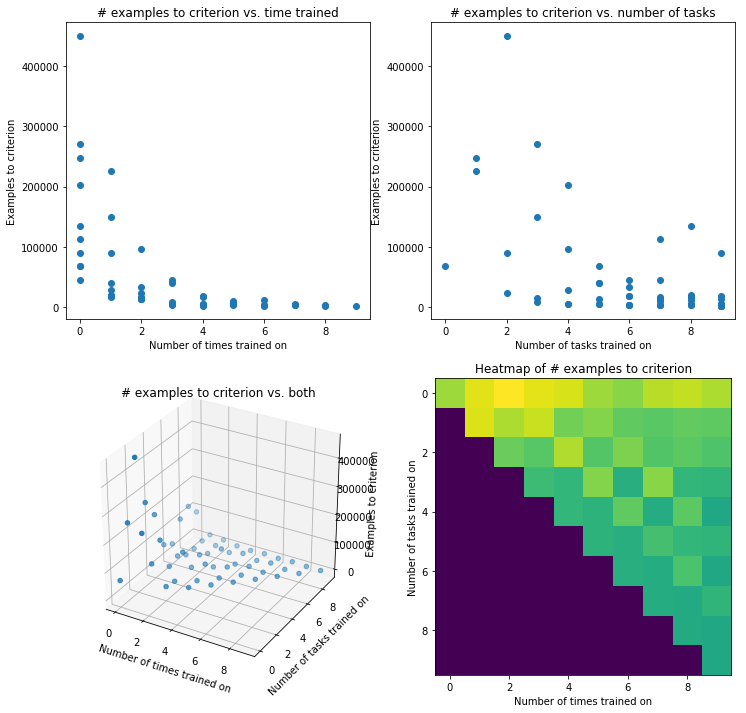

In [105]:
NROWS = 2
NCOLS = 2

def plot_examples_to_criterion(examples_to_criterion):
    figure = plt.figure(figsize=(12, 12))
    
    nonzero_rows, nonzero_cols = np.nonzero(examples_to_criterion)
    values = [examples_to_criterion[r, c] for (r, c) in zip(nonzero_rows, nonzero_cols)]
    
    # Accuracy as a function of # times trained on
    num_times_trained_ax = plt.subplot(NROWS, NCOLS, 1)
    num_times_trained_ax.scatter(nonzero_rows, values)
    
    num_times_trained_ax.set_xlabel('Number of times trained on')
    num_times_trained_ax.set_ylabel('Examples to criterion')
    num_times_trained_ax.set_title('# examples to criterion vs. time trained')
    
    # Accuracy as a function of how many total tasks
    num_current_tasks_ax = plt.subplot(NROWS, NCOLS, 2)
    num_current_tasks_ax.scatter(nonzero_cols, values)
    
    num_current_tasks_ax.set_xlabel('Number of tasks trained on')
    num_current_tasks_ax.set_ylabel('Examples to criterion')
    num_current_tasks_ax.set_title('# examples to criterion vs. number of tasks')
    
    # Accuracy as a function of both
    both_ax = plt.subplot(NROWS, NCOLS, 3, projection='3d')
    both_ax.scatter(nonzero_rows, nonzero_cols, values)
    
    both_ax.set_xlabel('Number of times trained on')
    both_ax.set_ylabel('Number of tasks trained on')
    both_ax.set_zlabel('Examples to criterion')
    both_ax.set_title('# examples to criterion vs. both')
    
    # Accuracy as a function of both in a heatmap
    heatmap_ax = plt.subplot(NROWS, NCOLS, 4)
    heatmap_ax.imshow(np.log(examples_to_criterion + 1))
    
    heatmap_ax.set_xlabel('Number of times trained on')
    heatmap_ax.set_ylabel('Number of tasks trained on')
    heatmap_ax.set_title('Heatmap of # examples to criterion')
    
    plt.show()

plot_examples_to_criterion(examples_to_criterion)


In [96]:
np.nonzero(examples_to_criterion)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6,
        7, 8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]))

In [55]:
ftf = df['Test Accuracy, Query #2'].first_valid_index()
stf = df['Test Accuracy, Query #3'].first_valid_index()
accs = df['Test Accuracy, Query #2'][ftf:stf + 20]

In [86]:
tabulate.tabulate?

Signature: tabulate.tabulate(tabular_data, headers=(), tablefmt='simple', floatfmt='g', numalign='decimal', stralign='left', missingval='', showindex='default', disable_numparse=False)
Docstring:
Format a fixed width table for pretty printing.

>>> print(tabulate([[1, 2.34], [-56, "8.999"], ["2", "10001"]]))
---  ---------
  1      2.34
-56      8.999
  2  10001
---  ---------

The first required argument (`tabular_data`) can be a
list-of-lists (or another iterable of iterables), a list of named
tuples, a dictionary of iterables, an iterable of dictionaries,
a two-dimensional NumPy array, NumPy record array, or a Pandas'
dataframe.


Table headers
-------------

To print nice column headers, supply the second argument (`headers`):

  - `headers` can be an explicit list of column headers
  - if `headers="firstrow"`, then the first row of data is used
  - if `headers="keys"`, then dictionary keys or column indices are used

Otherwise a headerless table is produced.

If the number of head

In [47]:
df[ftf:stf] > 0.95

,Test AUC,Test Accuracy,"Test Accuracy, Query #1","Test Accuracy, Query #10","Test Accuracy, Query #2","Test Accuracy, Query #3","Test Accuracy, Query #4","Test Accuracy, Query #5","Test Accuracy, Query #6","Test Accuracy, Query #7",...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
4,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
6,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
7,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
8,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
9,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
10,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
11,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
12,False,True,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
13,False,True,True,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [49]:
df[['Test AUC', 'Test Accuracy']]

,Test AUC,Test Accuracy
0,NaN,NaN
1,0.754295,74.500000
2,0.881109,88.000000
3,0.955544,95.250000
4,0.671759,67.714286
5,0.712645,70.571429
6,0.713336,71.142857
7,0.709874,70.571429
8,0.728535,72.000000
9,0.735588,72.428571
